In [1]:
from sympy import *
from sympy.abc import *
from sympy.galgebra.ga import *
import numpy as np
from numpy import linalg as LA
from __future__ import print_function
init_printing()

# 2D equations
The 2D equation for the TTI model are given by

## Forward


\begin{cases} 
 &m \frac{d^2 p(x,t)}{dt^2} - (1+2\epsilon)G_{\bar{x}\bar{x}} p(x,t) - \sqrt{(1+2\delta)}G_{\bar{z}\bar{z}} r(x,t) =q  \\
 &m \frac{d^2 r(x,t)}{dt^2} -  \sqrt{(1+2\delta)}G_{\bar{x}\bar{x}} p(x,t) - G_{\bar{z}\bar{z}} r(x,t) =q    \\
 &p(.,0) = 0 \\
 &\frac{d p(x,t)}{dt}|_{t=0} = 0 \\
 &r(.,0) = 0 \\
 &\frac{d r(x,t)}{dt}|_{t=0} = 0 
\end{cases}


## Adjoint

\begin{cases} 
 &m \frac{d^2 p(x,t)}{dt^2} - G_{\bar{x}\bar{x}}^T((1+2\epsilon) p(x,t)) - G_{\bar{z}\bar{z}}^T(\sqrt{(1+2\delta)} r(x,t)) =q  \\
 &m \frac{d^2 r(x,t)}{dt^2} -  G_{\bar{x}\bar{x}}^T(\sqrt{(1+2\delta)} p(x,t)) - G_{\bar{z}\bar{z}}^T r(x,t) =q    \\
 &p(.,0) = 0 \\
 &\frac{d p(x,t)}{dt}|_{t=0} = 0 \\
 &r(.,0) = 0 \\
 &\frac{d r(x,t)}{dt}|_{t=0} = 0 
\end{cases}


# Differential operators

where
\begin{cases} 
G_{\bar{x}\bar{x}} & = cos(\theta)^2 \frac{d^2}{dx^2} + sin(\theta)^2 \frac{d^2}{dz^2} - sin(2\theta) \frac{d^2}{dx dz} \\
G_{\bar{z}\bar{z}} & =  sin(\theta)^2 \frac{d^2}{dx^2} + cos(\theta)^2 \frac{d^2}{dz^2} +sin(2\theta) \frac{d^2}{dx dz} \\ 
\end{cases}


# Finite differences in practice
We will use a compact 4th order finite difference schemefor the cross derivatives

\begin{cases} 
  \frac{d^2 p(x,z)}{dx dz} = \frac{1}{2}(-2p(z,x,t) + p(z+h,x,t) + p(z-h,x,t) - p(z-h,x+h,t) + p(z,x-h,t) - p(z+h,x-h,t) + p(z,x+h,t))
\end{cases}

he Taylor expansion shows that with this scheme we have 
\begin{cases} 
  \frac{1}{2}(-2p(z,x,t) + p(z+h,x,t) + p(z-h,x,t) - p(z-h,x+h,t) + p(z,x-h,t) - p(z+h,x-h,t) + p(z,x+h,t)) = \frac{d^2 p(x,z)}{dx dz}+ O(dx^4,dz^4,dx^\alpha dz^\beta : \alpha+\beta >3)
\end{cases}

In [2]:
p=Function('p')
r=Function('r')

s,h,x,y,z = symbols('s h x y z')
m=M(z,x)
q=Q(z,x,t)
d=D(z,x,t)
e=E(z,x)

A=epsilon(z,x)  # (1 + 2epsilon) but make the symbolic simpler
B=delta(z,x) # sqrt(1 + 2epsilon) but make the symbolic simpler
Th=theta(z,x)

# Weights to sum the two fields
w1=.5
w2=.5

In [3]:
dttp=as_finite_diff(p(z,x,t).diff(t,t), [t-s,t, t+s])
dttr=as_finite_diff(r(z,x,t).diff(t,t), [t-s,t, t+s])
dtp=as_finite_diff(p(z,x,t).diff(t), [t-s,t])
dtr=as_finite_diff(r(z,x,t).diff(t), [t-s,t])
# Spacial finite differences can easily be extended to higher order by increasing the list of sampling point in the next expression. 
# Be sure to keep this stencil symmetric and everything else in the notebook will follow.
dxxp=as_finite_diff(p(z,x,t).diff(x,x), [x-h, x, x+h]) 
dzzp=as_finite_diff(p(z,x,t).diff(z,z), [z-h, z, z+h])
dxxr=as_finite_diff(r(z,x,t).diff(x,x), [x-h, x, x+h]) 
dzzr=as_finite_diff(r(z,x,t).diff(z,z), [z-h, z, z+h])

# My 4th order stencil for d/dxdy
dxzp = .5/(h**2)*(-2*p(z,x,t) + p(z+h,x,t) + p(z-h,x,t) - p(z-h,x+h,t) + p(z,x-h,t) - p(z+h,x-h,t) + p(z,x+h,t))
dxzr = .5/(h**2)*(-2*r(z,x,t) + r(z+h,x,t) + r(z-h,x,t) - r(z-h,x+h,t) + r(z,x-h,t) - r(z+h,x-h,t) + r(z,x+h,t))

In [4]:
arglambp=(p(z,x,t-s),
          p(z,x,t),
          p(z,x-h,t),
          p(z,x+h,t),
          p(z-h,x,t),
          p(z+h,x,t),
          p(z-h,x+h,t),
          p(z+h,x-h,t),
          r(z,x,t),
          r(z,x-h,t),
          r(z,x+h,t),
          r(z-h,x,t),
          r(z+h,x,t),
          r(z-h,x+h,t),
          r(z+h,x-h,t),
          q , 
          m,
          A,
          B,
          Th,
          s, 
          h,
          e)
arglambr=(r(z,x,t-s), 
          p(z,x,t),
          p(z,x-h,t),
          p(z,x+h,t),
          p(z-h,x,t),
          p(z+h,x,t),
          p(z-h,x+h,t),
          p(z+h,x-h,t),
          r(z,x,t),
          r(z,x-h,t),
          r(z,x+h,t),
          r(z-h,x,t),
          r(z+h,x,t),
          r(z-h,x+h,t),
          r(z+h,x-h,t),
          q , 
          m,
          A,
          B,
          Th,
          s, 
          h,
          e)

In [5]:
Gxxp=cos(Th)**2 * dxxp + sin(Th)**2 * dzzp - sin(2*Th)*dxzp
Gzzr=sin(Th)**2 * dxxr + cos(Th)**2 * dzzr + sin(2*Th)*dxzr

In [6]:
# Forward wave equation p
wavep = m * dttp - A * Gxxp - B * Gzzr - q 
#wavep

In [7]:
# Forward wave equation r
waver = m * dttr - B * Gxxp - Gzzr - q  
#waver

In [8]:
stencilp =solve(wavep,p(z,x,t+s),simplify=False)[0]
tsp=lambdify(arglambp,  stencilp,  "numpy")
#factor(stencilp)

In [9]:
#simplify(stencilp)

In [10]:
#arglambp

In [11]:
stencilr = solve(waver,r(z,x,t+s),simplify=False)[0]
tsr=lambdify(arglambr, stencilr,  "numpy")
#stencilr

In [12]:
import matplotlib.pyplot as plt
from matplotlib import animation

hstep=10.0 #space increment d  = minv/(10*f0);
tstep=1.0 #time increment dt < .5 * hstep /maxv;
tmin=0.0 #initial time
tmax=300 #simulate until
xmin=-500.0 - 10*hstep #left bound
xmax=500.0 + 10*hstep #right bound...assume packet never reaches boundary
zmin=-500.0 - 10*hstep #left bound
zmax=500.0 + 10*hstep #right bound...assume packet never reaches boundary
f0=0.015
t0=1/.015
nbpml=10
nx = int((xmax-xmin)/hstep) + 1 #number of points on x grid
nz = int((zmax-zmin)/hstep) + 1 #number of points on x grid
nt = int((tmax-tmin)/tstep) + 2 #number of points on t grid
xsrc=0.0
zsrc=0.0
zrec = int(nz/4)
#set source as Ricker wavelet for f0 
def source(z,x,t):
    r = (np.pi*f0*(t-t0))
    val = (1-2.*r**2)*np.exp(-r**2)
    if abs(x-xsrc)<hstep/2 and abs(z-zsrc)<hstep/2:
        return val
    else:
        return 0.0
    
def dampx(x):
    dampcoeff=np.log(1.0/0.001)/(5.0*hstep);
    if x<nbpml:
        return dampcoeff*((nbpml-x)/nbpml)**2
    elif x>nx-nbpml-1:
        return dampcoeff*((x-nx+nbpml)/nbpml)**2
    else:
        return 0.0
def dampz(z):
    dampcoeff=np.log(1.0/0.001)/(5.0*hstep);
    if z<nbpml:
        return dampcoeff*((nbpml-z)/nbpml)**2
    elif z>nz-nbpml-1:
        return dampcoeff*((z-nz+nbpml)/nbpml)**2
    else:
        return 0.0

In [13]:
# Velocity models
def smooth10(vel,nz,nx):
    out=np.ones((nz,nx))
    out[:,:]=vel[:,:]
    for a in range(5,nz-6):
        out[a,:]=np.sum(vel[a-5:a+5,:], axis=0) /10
    return out

# True velocity
vel=np.ones((nz,nx)) + .4
#vel[floor(nz/2):nz,:]=4.5
mt=vel**-2
# Smooth velocity
v0=smooth10(vel,nz,nx)
m0=v0**-2
eps=1+2*(np.ones((nz,nx)) -.6)
#eps[0:30,:]=1;
eps=smooth10(eps,nz,nx);
delt=np.sqrt(1+2*np.ones((nz,nx)) -1.6)
#delt[0:30,:]=1;
delt=smooth10(delt,nz,nx);
the=np.pi/5*np.ones((nz,nx));
#the[0:30,:]=0;
the=smooth10(the,nz,nx);
dm=m0-mt

In [14]:
def Forward(nt,nz,nx,m,eps,delt,the):
    u1=np.zeros((nt+2,nz,nx))
    u2=np.zeros((nt+2,nz,nx))
    rec=np.zeros((nt,nx-2))
    for ti in range(0,nt):
        for a in range(1,nz-1):
            for b in range(1,nx-1):
                src = source(zmin+a*hstep,xmin+b*hstep,tstep*ti)
                damp=dampz(a)+dampx(b)
                u1[ti+2,a,b]=tsp(u1[ti,a,b],
                                 u1[ti+1,a,b],
                                 u1[ti+1,a,b-1],
                                 u1[ti+1,a,b+1],
                                 u1[ti+1,a-1,b],
                                 u1[ti+1,a+1,b],
                                 u1[ti+1,a-1,b+1],
                                 u1[ti+1,a+1,b-1],
                                 u2[ti+1,a,b],
                                 u2[ti+1,a,b-1],
                                 u2[ti+1,a,b+1],
                                 u2[ti+1,a-1,b],
                                 u2[ti+1,a+1,b],
                                 u2[ti+1,a-1,b+1],
                                 u2[ti+1,a+1,b-1],
                                 .5*src , 
                                 m[a,b],
                                 eps[a,b],
                                 delt[a,b],
                                 the[a,b],
                                 tstep,
                                 hstep,
                                 damp)
                u2[ti+2,a,b]=tsr(u2[ti,a,b],
                                 u1[ti+1,a,b],
                                 u1[ti+1,a,b-1],
                                 u1[ti+1,a,b+1],
                                 u1[ti+1,a-1,b],
                                 u1[ti+1,a+1,b],
                                 u1[ti+1,a-1,b+1],
                                 u1[ti+1,a+1,b-1],
                                 u2[ti+1,a,b],
                                 u2[ti+1,a,b-1],
                                 u2[ti+1,a,b+1],
                                 u2[ti+1,a-1,b],
                                 u2[ti+1,a+1,b],
                                 u2[ti+1,a-1,b+1],
                                 u2[ti+1,a+1,b-1],
                                 .5*src , 
                                 m[a,b],
                                 eps[a,b],
                                 delt[a,b],
                                 the[a,b],
                                 tstep,
                                 hstep,
                                 damp)
                if a==zrec :
                    rec[ti,b-1]=(.5*u1[ti+2,a,b] + .5*u2[ti+2,a,b])
    return rec,u1,u2

In [15]:
(rect,u1,u2)=Forward(nt,nz,nx,mt,eps,delt,the)

In [16]:

#fig = plt.figure()
#plts = []             # get ready to populate this list the Line artists to be plotted
#plt.hold("off")
#for i in range(nt):
#    r = plt.imshow(u1[i,:,:],vmin=-1,vmax=1)   # this is how you'd plot a single line...
#    plts.append( [r] )  
#ani = animation.ArtistAnimation(fig, plts, interval=50,  repeat = False)   # run the animation
#plt.show()

In [17]:
#fig2 = plt.figure()
#plt.hold("off")
#shotrec = plt.imshow(rect)   # this is how you'd plot a single line...
#plt.show()

In [18]:
#fig2 = plt.figure()
#plt.hold("off")
#shotrec = plt.imshow(eps)   # this is how you'd plot a single line...
#plt.show()
#fig2 = plt.figure()
#plt.hold("off")
#shotrec = plt.imshow(delt)   # this is how you'd plot a single line...
#plt.show()
#fig2 = plt.figure()
#plt.hold("off")
#shotrec = plt.imshow(the)   # this is how you'd plot a single line...
#plt.show()

# Adjoint

In [19]:
A=Function('A')
B=Function('B')
r=Function('r')
# Need to do it by hand as it is not supported
dxxpe= 1/(h**2)*(-2*A(z,x)*p(z,x,t) + A(z,x+h)*p(z,x+h,t) + A(z,x-h)*p(z,x-h,t))
dzzpe= 1/(h**2)*(-2*A(z,x)*p(z,x,t) + A(z+h,x)*p(z+h,x,t) + A(z-h,x)*p(z-h,x,t))

dxxpd= 1/(h**2)*(-2*B(z,x)*p(z,x,t) + B(z,x+h)*p(z,x+h,t) + B(z,x-h)*p(z,x-h,t))
dzzpd= 1/(h**2)*(-2*B(z,x)*p(z,x,t) + B(z+h,x)*p(z+h,x,t) + B(z-h,x)*p(z-h,x,t))
dxxrd= 1/(h**2)*(-2*B(z,x)*r(z,x,t) + B(z,x+h)*r(z,x+h,t) + B(z,x-h)*r(z,x-h,t))
dzzrd= 1/(h**2)*(-2*B(z,x)*r(z,x,t) + B(z+h,x)*r(z+h,x,t) + B(z-h,x)*r(z-h,x,t))

# My 4th order stencil for d/dxdy
dxzpe = .5/(h**2)*(-2*A(z,x)*p(z,x,t) + A(z+h,x)*p(z+h,x,t) + A(z-h,x)*p(z-h,x,t) -
                   A(z-h,x+h)*p(z-h,x+h,t) + A(z,x-h)*p(z,x-h,t) - A(z+h,x-h)*p(z+h,x-h,t) + A(z,x+h)*p(z,x+h,t))

dxzpd = .5/(h**2)*(-2*B(z,x)*p(z,x,t) + B(z+h,x)*p(z+h,x,t) + B(z-h,x)*p(z-h,x,t) -
                   B(z-h,x+h)*p(z-h,x+h,t) + B(z,x-h)*p(z,x-h,t) - B(z+h,x-h)*p(z+h,x-h,t) + B(z,x+h)*p(z,x+h,t))
dxzrd = .5/(h**2)*(-2*B(z,x)*r(z,x,t) + B(z+h,x)*r(z+h,x,t) + B(z-h,x)*r(z-h,x,t) -
                   B(z-h,x+h)*r(z-h,x+h,t) + B(z,x-h)*r(z,x-h,t) - B(z+h,x-h)*r(z+h,x-h,t) + B(z,x+h)*r(z,x+h,t))

In [20]:
Gxxpe=cos(Th)**2 * dxxpe + sin(Th)**2 * dzzpe - sin(2*Th)*dxzpe
Gzzrd=sin(Th)**2 * dxxrd + cos(Th)**2 * dzzrd + sin(2*Th)*dxzrd
Gxxpd=cos(Th)**2 * dxxpd + sin(Th)**2 * dzzpd - sin(2*Th)*dxzpd

In [21]:
# Forward wave equation r
wavepa = m * dttp -  Gxxpe - Gzzrd - q  
#waver

In [22]:
# Forward wave equation p
wavera = m * dttr -  Gxxpd -  Gzzr - q 
#wavep

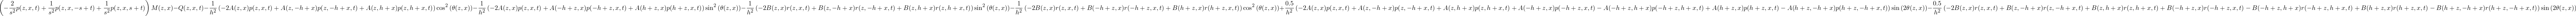

In [23]:
wavepa

In [24]:
arglambpa=(p(z,x,t+s),
          p(z,x,t),
          p(z,x-h,t),
          p(z,x+h,t),
          p(z-h,x,t),
          p(z+h,x,t),
          p(z-h,x+h,t),
          p(z+h,x-h,t),
          r(z,x,t),
          r(z,x-h,t),
          r(z,x+h,t),
          r(z-h,x,t),
          r(z+h,x,t),
          r(z-h,x+h,t),
          r(z+h,x-h,t),
          A(z,x),
          A(z,x-h),
          A(z,x+h),
          A(z-h,x),
          A(z+h,x),
          A(z-h,x+h),
          A(z+h,x-h),
          B(z,x),
          B(z,x-h),
          B(z,x+h),
          B(z-h,x),
          B(z+h,x),
          B(z-h,x+h),
          B(z+h,x-h),
          q , 
          m,
          Th,
          s, 
          h,
          e)
arglambra=(r(z,x,t+s), 
          p(z,x,t),
          p(z,x-h,t),
          p(z,x+h,t),
          p(z-h,x,t),
          p(z+h,x,t),
          p(z-h,x+h,t),
          p(z+h,x-h,t),
          r(z,x,t),
          r(z,x-h,t),
          r(z,x+h,t),
          r(z-h,x,t),
          r(z+h,x,t),
          r(z-h,x+h,t),
          r(z+h,x-h,t),
          B(z,x),
          B(z,x-h),
          B(z,x+h),
          B(z-h,x),
          B(z+h,x),
          B(z-h,x+h),
          B(z+h,x-h),
          q , 
          m,
          Th,
          s, 
          h,
          e)

In [25]:
arglambpa

In [26]:
stencilpa =solve(wavepa,p(z,x,t-s),simplify=False)[0]
tspa=lambdify(arglambpa,  stencilpa,  "numpy")
#factor(stencilp)

In [27]:
stencilra =solve(wavera,r(z,x,t-s),simplify=False)[0]
tsra=lambdify(arglambra,  stencilra,  "numpy")
#factor(stencilp)

In [28]:
def Adjoint(nt,nz,nx,m,eps,delt,the,rec):
    u1=np.zeros((nt+2,nz,nx))
    u2=np.zeros((nt+2,nz,nx))
    srca=np.zeros((nt))
    for ti in  range(nt-1, -1, -1):
        for a in range(1,nz-1):
            for b in range(1,nx-1):
                if a==zrec:
                    resid=rec[ti,b-1]
                else:
                    resid=0
                damp=dampz(a)+dampx(b)
                u1[ti,a,b]=tspa(u1[ti+2,a,b],
                                 u1[ti+1,a,b],
                                 u1[ti+1,a,b-1],
                                 u1[ti+1,a,b+1],
                                 u1[ti+1,a-1,b],
                                 u1[ti+1,a+1,b],
                                 u1[ti+1,a-1,b+1],
                                 u1[ti+1,a+1,b-1],
                                 u2[ti+1,a,b],
                                 u2[ti+1,a,b-1],
                                 u2[ti+1,a,b+1],
                                 u2[ti+1,a-1,b],
                                 u2[ti+1,a+1,b],
                                 u2[ti+1,a-1,b+1],
                                 u2[ti+1,a+1,b-1],
                                 eps[a,b],
                                 eps[a,b-1],
                                 eps[a,b+1],
                                 eps[a-1,b],
                                 eps[a+1,b],
                                 eps[a-1,b+1],
                                 eps[a+1,b-1],
                                 delt[a,b],
                                 delt[a,b-1],
                                 delt[a,b+1],
                                 delt[a-1,b],
                                 delt[a+1,b],
                                 delt[a-1,b+1],
                                 delt[a+1,b-1],
                                 .5*resid , 
                                 m[a,b],
                                 the[a,b],
                                 tstep,
                                 hstep,
                                 damp)
                u2[ti,a,b]=tsra(u2[ti+2,a,b],
                                 u1[ti+1,a,b],
                                 u1[ti+1,a,b-1],
                                 u1[ti+1,a,b+1],
                                 u1[ti+1,a-1,b],
                                 u1[ti+1,a+1,b],
                                 u1[ti+1,a-1,b+1],
                                 u1[ti+1,a+1,b-1],
                                 u2[ti+1,a,b],
                                 u2[ti+1,a,b-1],
                                 u2[ti+1,a,b+1],
                                 u2[ti+1,a-1,b],
                                 u2[ti+1,a+1,b],
                                 u2[ti+1,a-1,b+1],
                                 u2[ti+1,a+1,b-1],
                                 delt[a,b],
                                 delt[a,b-1],
                                 delt[a,b+1],
                                 delt[a-1,b],
                                 delt[a+1,b],
                                 delt[a-1,b+1],
                                 delt[a+1,b-1],
                                 .5*resid , 
                                 m[a,b],
                                 the[a,b],
                                 tstep,
                                 hstep,
                                 damp)
                if abs(xmin+b*hstep-xsrc)<hstep/2 and abs(zmin+a*hstep-zsrc)<hstep/2:
                    srca[ti]=.5*u1[ti,a,b]+.5*u2[ti,a,b]
    return srca,u1,u2

In [29]:
(srca,u1,u2)=Adjoint(nt,nz,nx,mt,eps,delt,the,rect)

In [33]:
# Actual adjoint test
term1=0
for ti in range(0,nt):
    term1=term1+srca[ti]*source(xsrc,zsrc,(ti)*tstep)

term2=LA.norm(rect)**2

term1,term2,term1-term2,term1/term2

In [31]:
fig = plt.figure()
plts = []             # get ready to populate this list the Line artists to be plotted
plt.hold("off")
for i in range(nt):
    r = plt.imshow(u1[nt-i,:,:]+u2[nt-i,:,:],vmin=-1,vmax=1)   # this is how you'd plot a single line...
    plts.append( [r] )  
ani = animation.ArtistAnimation(fig, plts, interval=50,  repeat = False)   # run the animation
plt.show()

In [34]:

shotrec = plt.plot(srca)   # this is how you'd plot a single line...
plt.show()